In [12]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 5)
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

%matplotlib inline

## Ingest and EDA

In [2]:
# Ingest the data
weather_train = pd.read_csv('data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
weather_train

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [3]:
weather_train.shape

(1462, 4)

In [4]:
# Ingest the testing data
weather_test = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)
weather_test

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [5]:
weather_test.shape

(114, 4)

observation: The last element in train is also in trest

In [6]:
# Drop the last column in train
print(weather_train.shape)
weather_train = weather_train.drop(index=["2017-01-01"])
print(weather_train.shape)

(1462, 4)
(1461, 4)


In [7]:
# weather_train.tail()

In [8]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2013-01-01 to 2016-12-31
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1461 non-null   float64
 1   humidity      1461 non-null   float64
 2   wind_speed    1461 non-null   float64
 3   meanpressure  1461 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [9]:
# Get some description
weather_train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197
std,7.339416,16.743928,4.559688,180.293335
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.571429
50%,27.714286,62.625000,6.250000,1008.555556
75%,31.312500,72.125000,9.250000,1014.937500
max,38.714286,98.000000,42.220000,7679.333333


Before we go too far. See if the time series can be modelled

In [ ]:
# Test for stationarity
ADF_result = adfuller(weather_train["meantemp"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

We cannot reject the null hypothesis
The data is not stationary. 

In [10]:
# Difference the data
mean_temp_diff = np.diff(weather_train["meantemp"], n=1)

In [13]:
ADF_result = adfuller(mean_temp_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -16.52044059233267
p-value: 2.0666135559465838e-29


The p value is < 0.05
Therefore we reject the null hypothesis and conclude tha the data is now stationary

plot the acf plot to see whether the data is a random walk or not

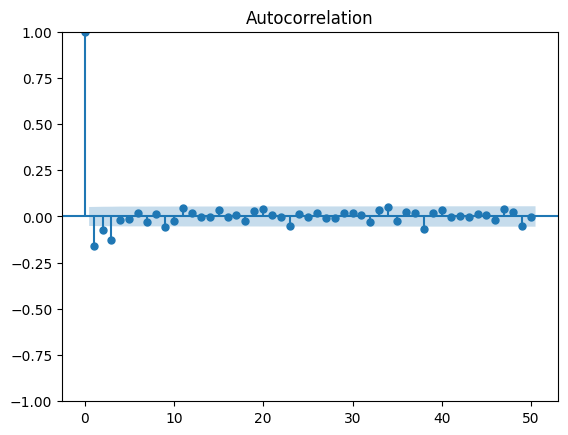

In [14]:
plot_acf(mean_temp_diff, lags=50);

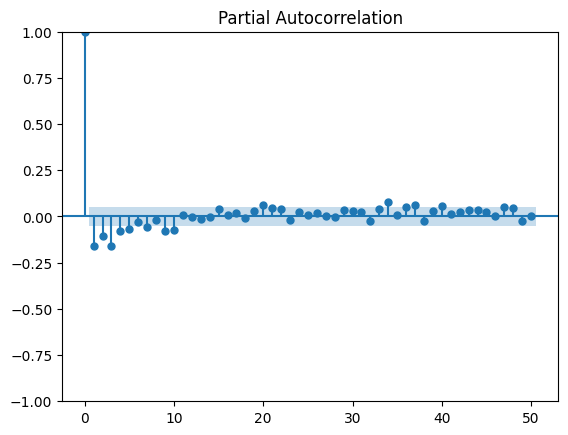

In [15]:
plot_pacf(mean_temp_diff,lags=50);

It is not a random walk

Continue exploration

<Axes: xlabel='meantemp'>

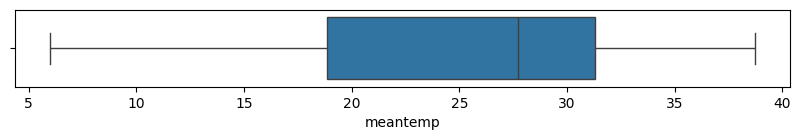

In [17]:
# Boxplots
plt.figure(figsize=(10, 1))
sns.boxplot(data=weather_train, x='meantemp')
plt.title("Boxplot for mean temperature");

<Axes: xlabel='humidity'>

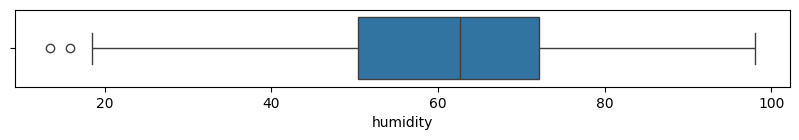

In [18]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=weather_train, x='humidity')
plt.title("Boxplot for Humidity");

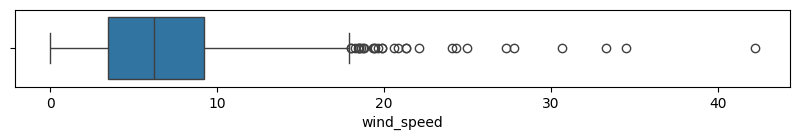

In [19]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=weather_train, x='wind_speed')
plt.title("Boxplot for Windspeed");

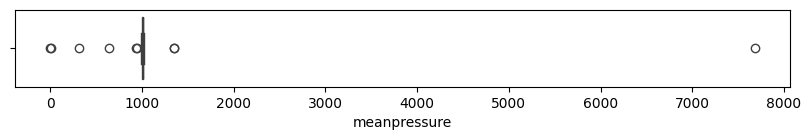

In [20]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=weather_train, x='meanpressure')
plt.title("Boxplot for mean pressure");

Observation: 
We need to perfomr outlier removal  
We also need to know the unit for the parameters  

Mean temperature

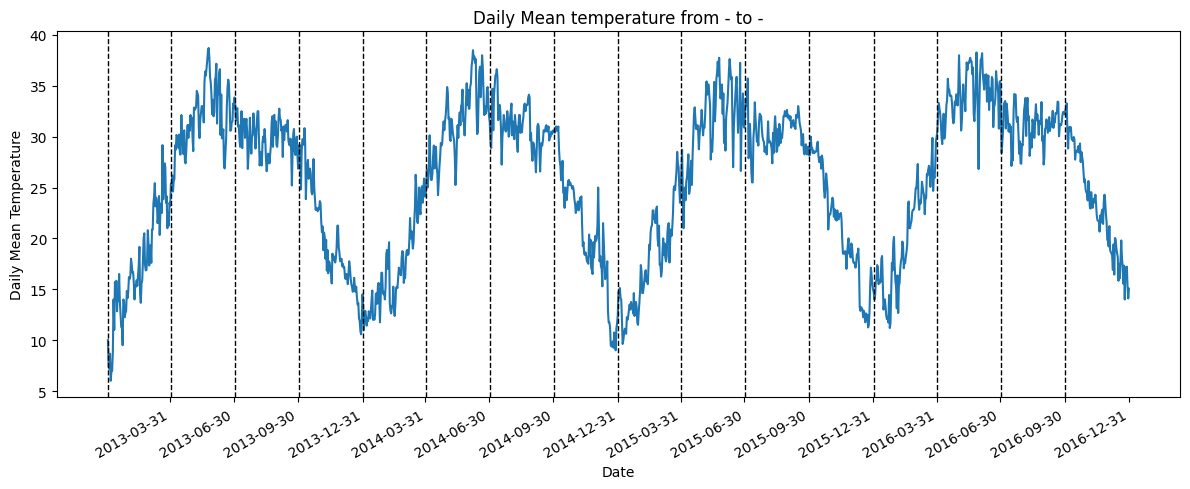

In [49]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(weather_train['meantemp'])
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Temperature')
ax.set_title("Daily Mean temperature from 2013 to 2016")

plt.xticks(pd.date_range(weather_train.index.min(), weather_train.index.max(), freq='Q'))

for i in pd.date_range(weather_train.index.min(), weather_train.index.max(), freq="QS"):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

fig.autofmt_xdate()
plt.tight_layout()

Theres a yearly seasonality in the data. The same patterns are occuring every year.
The year starts of low and incrase steadily then it peaks. Reduces a little bit. Then it decreases towards the end of the year

Let's decompose

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [33]:
weather_decomposition = STL(weather_train["meantemp"], period=365).fit()

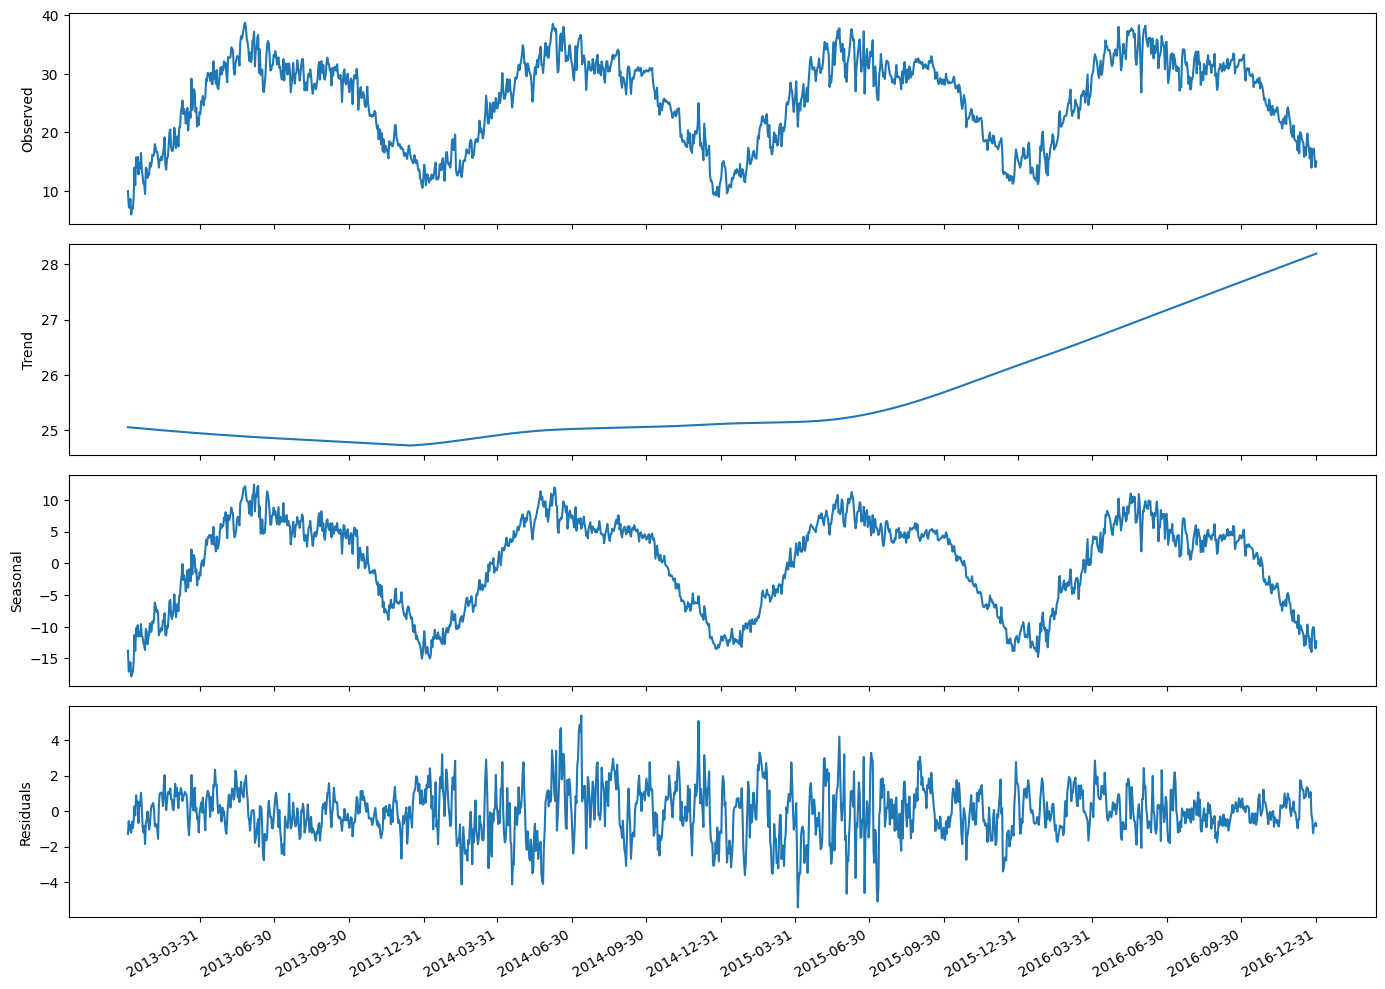

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

ax1.plot(weather_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(weather_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(weather_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(weather_decomposition.resid)
ax4.set_ylabel('Residuals')



fig.autofmt_xdate()
plt.tight_layout()

Seems like temperature is increasing over the years
The seasonality is confirmed by by the seasonal plot. Nothing we haven't seen in the training data


Try a monthly decomposition

In [36]:
# Monthly decomposition
weather_decomposition_2 = STL(weather_train["meantemp"], period=30).fit()

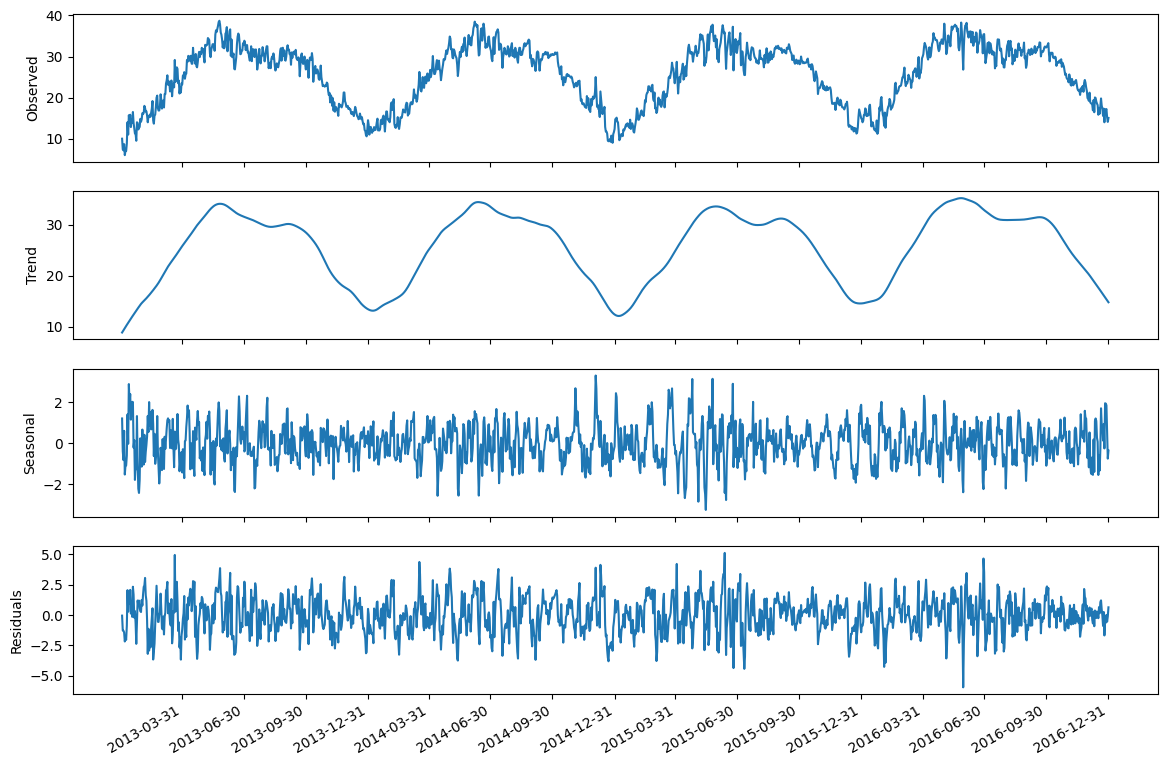

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 10))

ax1.plot(weather_decomposition_2.observed)
ax1.set_ylabel('Observed')

ax2.plot(weather_decomposition_2.trend)
ax2.set_ylabel('Trend')

ax3.plot(weather_decomposition_2.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(weather_decomposition_2.resid)
ax4.set_ylabel('Residuals')

plt.xticks(pd.date_range(weather_train.index.min(), weather_train.index.max(), freq='Q'))

fig.autofmt_xdate()
# plt.tight_layout()

There's no inherent pattern within the months. Thats why the seasonality is that way

But in the yearly decomposition. It is obvious that there's a yearly pattern. i.e If it was really hot on x day or x month last year, then it will be really hot in the same period this year

Let's add new column for further exploration

In [50]:
# Create some new columns
def new_cols(df):
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day_of_month"] = df.index.day
    df["weekday"] = df.index.weekday
    df['quarter'] = df.index.quarter
    df["day_of_year"] = df.index.dayofyear
    
    return df

In [51]:
weather_train = new_cols(weather_train)
weather_train.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1,1,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2,2,1,2
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3,3,1,3
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4,4,1,4
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5,5,1,5


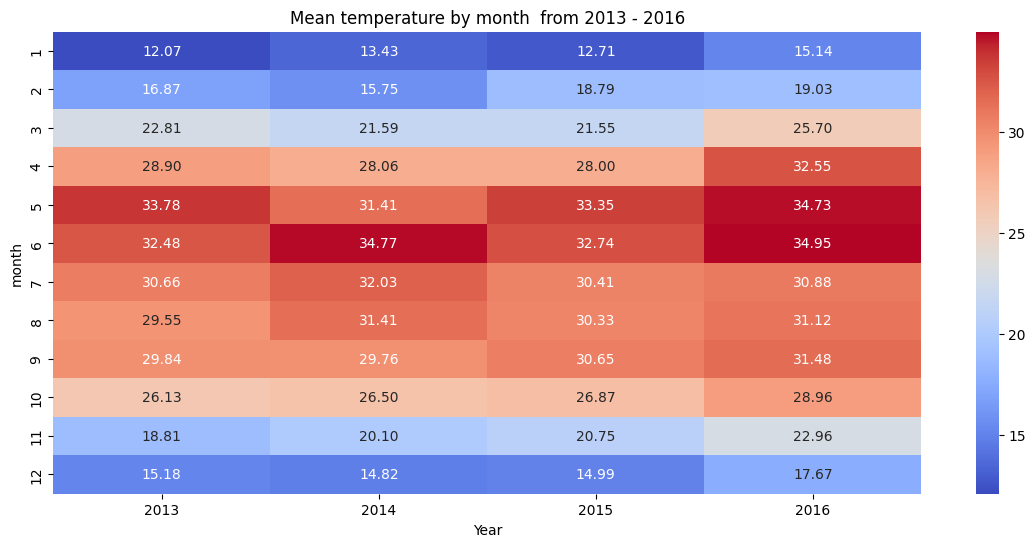

In [56]:
# Average temperature per month
pivot_table = weather_train.pivot_table(values='meantemp', index='month', columns='year', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Mean temperature by month  from 2013 - 2016')
plt.xlabel('Year')
plt.show();

Theres a monthly pattern here. The year starts of cold and goes hot and then back to cold again

may and june are the hottest

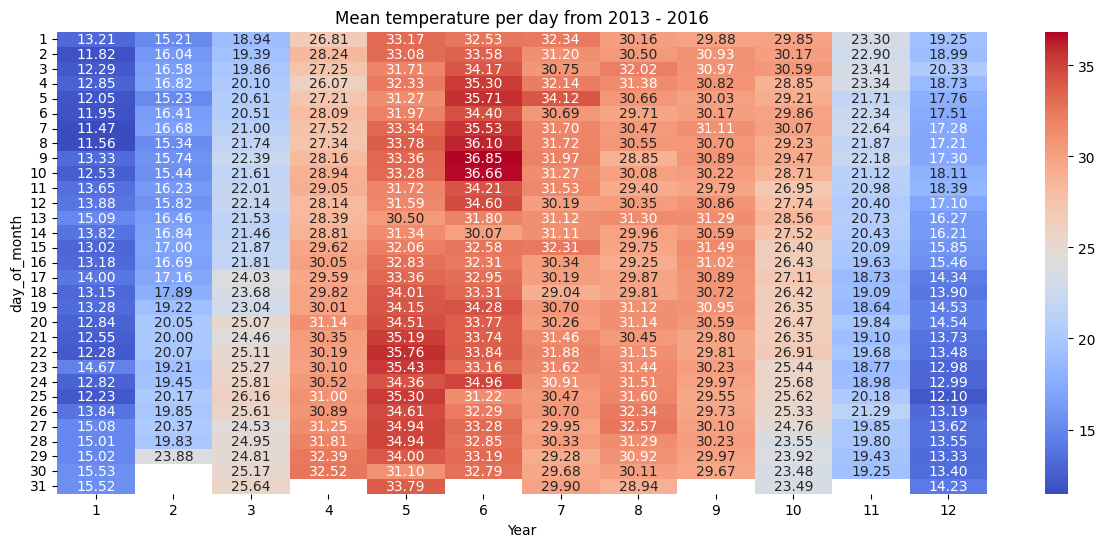

In [58]:
# Average temperature per day from 2013 - 2016
pivot_table = weather_train.pivot_table(values='meantemp', index='day_of_month', columns='month', aggfunc='mean')
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Mean temperature per day from 2013 - 2016')
plt.xlabel('Year')
plt.show();

The monthyl pattern observed above is clearer here
I can see that the the end of march signals the beginning of the highest temperature of the year
The temperatuer increases steadily till may and june where the highest temperature of the year are recorded. 
then it reduces a bit in july, august and september. 
By october, the temperature decreases steadilly till december


The plot is suggesting that theres no daily pattern. But there's surely a monthly pattern

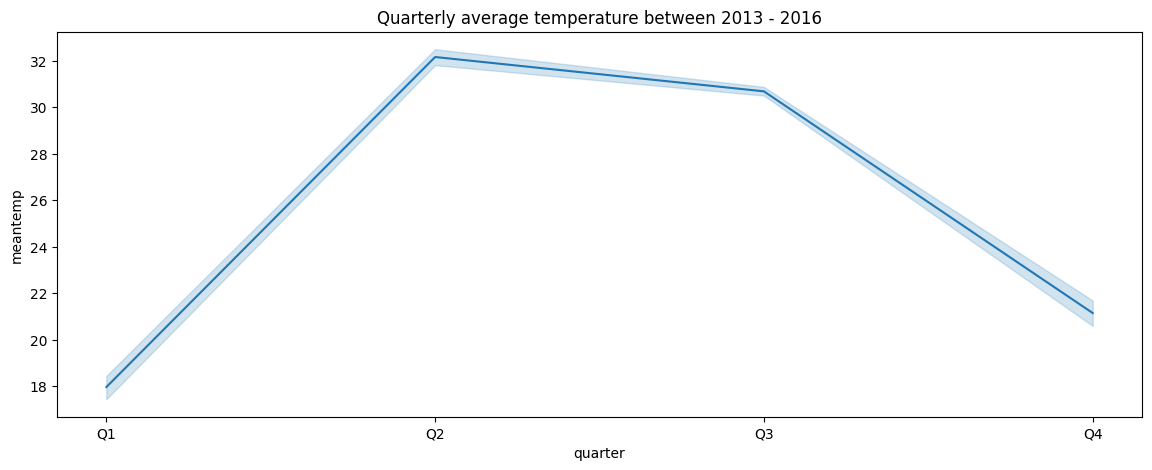

In [59]:
# Average temperatuer per quarter
fig, ax = plt.subplots()
sns.lineplot(ax=ax, data=weather_train, x='quarter', y='meantemp', ci=95)
ax.set_title('Combined quarterly average temperature between 2013 - 2016');
plt.show()

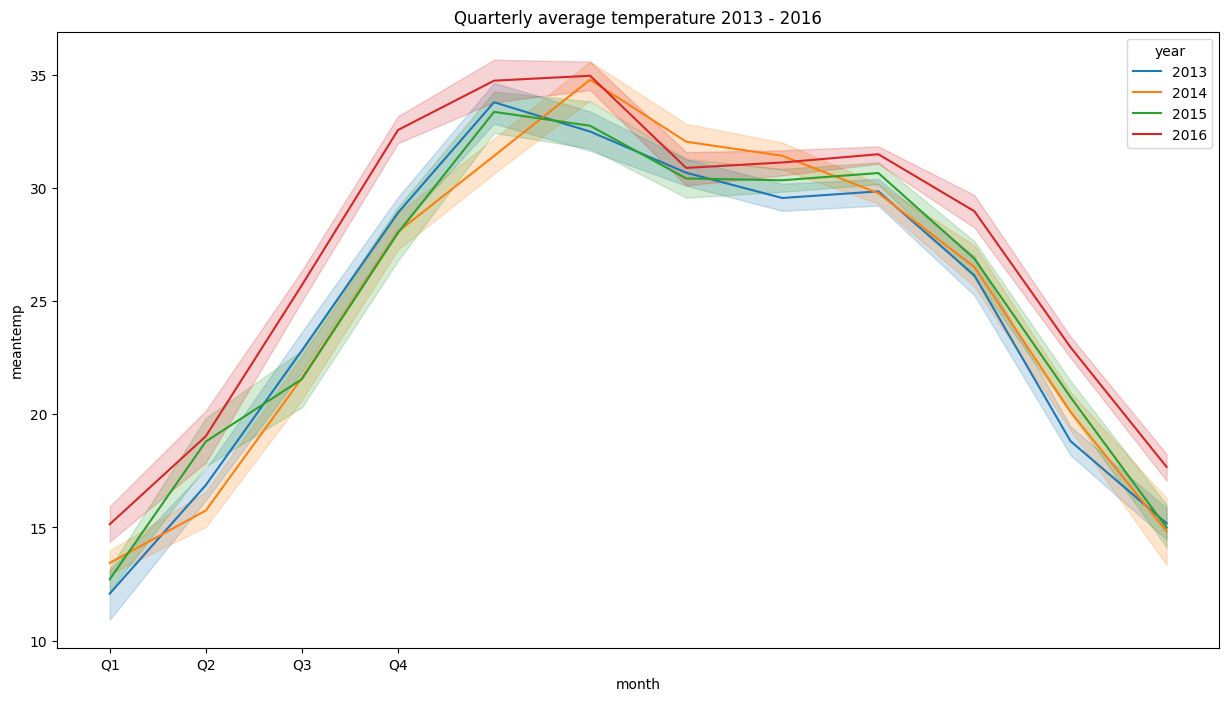

In [68]:
plt.figure(figsize=(15,8))
sns.lineplot(data=weather_train ,x='month',y='meantemp',hue='year', palette='tab10')
# plt.xticks([1,2,3,4], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.title('Quarterly average temperature 2013 - 2016');

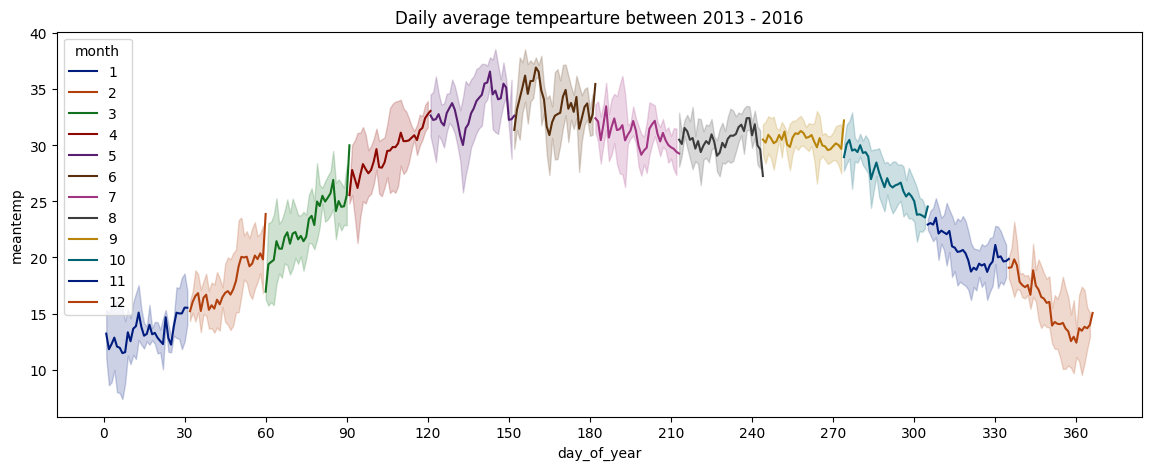

In [72]:
fig, ax = plt.subplots()
sns.lineplot(ax=ax, data=weather_train, x='day_of_year', y='meantemp', hue='month', errorbar=('sd', .95), palette='dark')
ax.set_xticks(range(0,366,30))
ax.set_title('Daily average tempearture between 2013 - 2016')
plt.show()

This makes it more clearer

Define a wrangle function to get the prepared data

In [16]:
def get_prepared_data(set):
    """
    Returns a DataFrame containg train or test set based on what you specify

    set : 'train' for train set. 'test' for test set
    """

    if set == 'train':
        df = pd.read_csv('data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
        df = df.drop(index=["2017-01-01"])
        assert df.shape == (1461, 4), "Did you change the train set. If you did, then you need to modify this wrangle function"
    elif set == 'test':
        df = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

    # Create new columns
    df.index.freq = 'D'
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day_of_month"] = df.index.day
    df["weekday"] = df.index.weekday
    df['quarter'] = df.index.quarter
    df["day_of_year"] = df.index.dayofyear

    return df

In [17]:
tr = get_prepared_data('train')
tr.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=1461, freq='D')